# Cybersecurity — Suspicious Web Traffic Analysis

**Dataset path (Colab):** `/content/CloudWatch_Traffic_Web_Attack.csv`

This notebook follows the project brief and includes: data loading, cleaning, EDA, feature engineering, two simple models (IsolationForest for anomalies and RandomForest for classification), visualizations, and final notes. Code is kept clear and commented for a student-level submission.

---

## 1) Imports and Settings

Import required libraries and set plotting style.

In [1]:

# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Display settings
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)
sns.set(style='whitegrid')

print('Libraries imported.')


Libraries imported.


## 2) Load the dataset



In [2]:

# Load CSV (path provided for Colab)
csv_path = '/content/CloudWatch_Traffic_Web_Attack.csv'
df = pd.read_csv(csv_path)

# Quick overview
print('Shape:', df.shape)
display(df.head())
display(df.info())


Shape: (282, 16)


,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null    object
 10  rule_names           282 non-null    object
 11  observation_name     282 non-null    object
 12  source.meta          282 non-null    object
 13  source.name          282 non-null    object
 14  time                 282 non-null    object
 15  detection_types      282 non-null    object
dtypes: int64

None

## 3) Data cleaning

- Check for duplicates, missing values
- Convert timestamps to datetime
- Standardize country codes
- Create a copy for transformed data

In [3]:

# 3.1 Check missing values and duplicates
print('Missing values per column:\n', df.isnull().sum())
print('\nDuplicate rows:', df.duplicated().sum())

data = df.copy()

# 3.2 Convert time columns to datetime if present
time_cols = [c for c in data.columns if 'time' in c.lower()]
for c in time_cols:
    try:
        data[c] = pd.to_datetime(data[c], utc=True)
    except Exception as e:
        print(f'Could not convert column {c} to datetime: {e}')

print('\nDetected time columns:', time_cols)

# 3.3 Standardize text fields
if 'src_ip_country_code' in data.columns:
    data['src_ip_country_code'] = data['src_ip_country_code'].astype(str).str.upper().str.strip()

# 3.4 Ensure numeric columns are numeric
for col in ['bytes_in', 'bytes_out', 'response.code', 'dst_port']:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
display(data.head())


Missing values per column:
 bytes_in               0
bytes_out              0
creation_time          0
end_time               0
src_ip                 0
src_ip_country_code    0
protocol               0
response.code          0
dst_port               0
dst_ip                 0
rule_names             0
observation_name       0
source.meta            0
source.name            0
time                   0
detection_types        0
dtype: int64

Duplicate rows: 0

Detected time columns: ['creation_time', 'end_time', 'time']


,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule
1,30912,18186,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule
2,28506,13468,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule
3,30546,14278,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule
4,6526,13892,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule


## 4) Exploratory Data Analysis (EDA)

Simple, insightful visuals and summary stats.

,count,mean,std,min,25%,50%,75%,max
bytes_in,282.0,1.199390e+06,4.149312e+06,40.0,5381.5,13182.0,30833.0,25207794.0
bytes_out,282.0,8.455429e+04,2.549279e+05,44.0,11142.0,13799.5,26279.5,1561220.0
response.code,282.0,2.000000e+02,0.000000e+00,200.0,200.0,200.0,200.0,200.0
dst_port,282.0,4.430000e+02,0.000000e+00,443.0,443.0,443.0,443.0,443.0


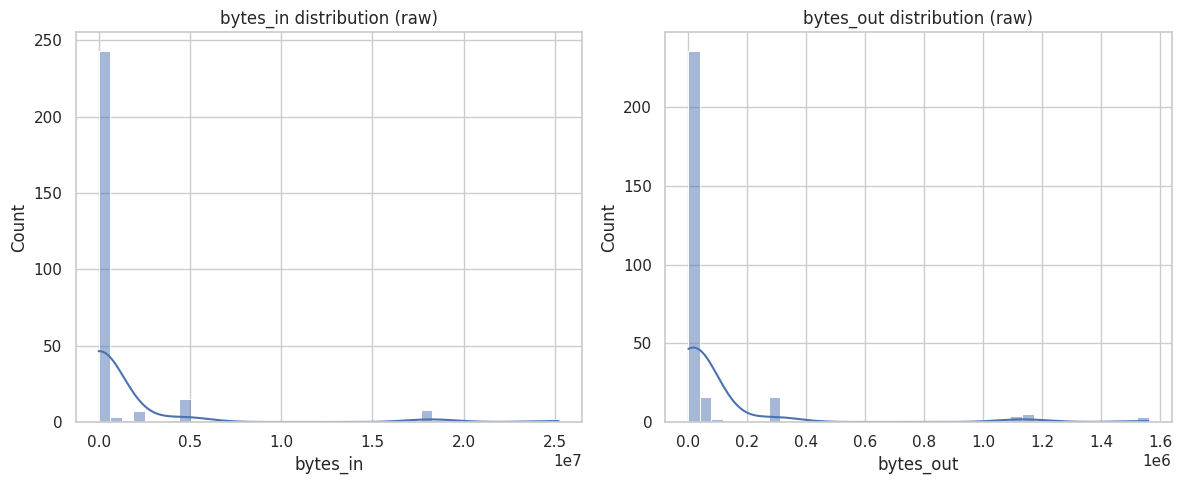

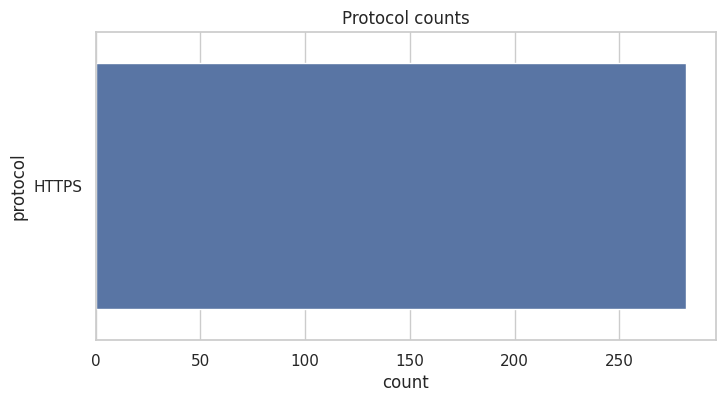

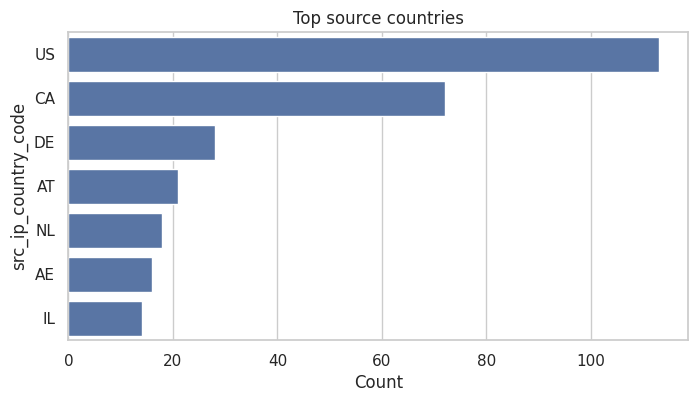

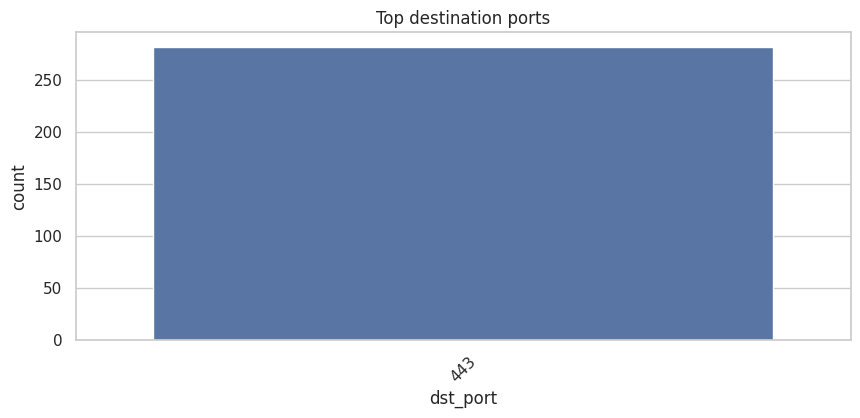

In [4]:

# 4.1 Descriptive statistics for numeric columns
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
display(data[num_cols].describe().T)

# 4.2 Distribution of bytes_in and bytes_out (raw histograms)
plt.figure(figsize=(12,5))
if 'bytes_in' in data.columns and 'bytes_out' in data.columns:
    plt.subplot(1,2,1)
    sns.histplot(data['bytes_in'].replace(0, np.nan).dropna(), bins=40, kde=True)
    plt.title('bytes_in distribution (raw)')

    plt.subplot(1,2,2)
    sns.histplot(data['bytes_out'].replace(0, np.nan).dropna(), bins=40, kde=True)
    plt.title('bytes_out distribution (raw)')
    plt.tight_layout()
    plt.show()

# 4.3 Protocol counts
if 'protocol' in data.columns:
    plt.figure(figsize=(8,4))
    sns.countplot(y='protocol', data=data, order=data['protocol'].value_counts().index)
    plt.title('Protocol counts')
    plt.show()

# 4.4 Top source countries by count
if 'src_ip_country_code' in data.columns:
    top_countries = data['src_ip_country_code'].value_counts().nlargest(10)
    plt.figure(figsize=(8,4))
    sns.barplot(x=top_countries.values, y=top_countries.index)
    plt.title('Top source countries')
    plt.xlabel('Count')
    plt.show()

# 4.5 Ports used (top)
if 'dst_port' in data.columns:
    plt.figure(figsize=(10,4))
    sns.countplot(x='dst_port', data=data, order=data['dst_port'].value_counts().index[:15])
    plt.xticks(rotation=45)
    plt.title('Top destination ports')
    plt.show()


## 5) Feature engineering

- session_duration (seconds)
- avg_packet_size
- simple scaling and encoding examples


In [5]:

# 5.1 Create session duration if creation_time and end_time exist
if 'creation_time' in data.columns and 'end_time' in data.columns:
    data['session_duration'] = (data['end_time'] - data['creation_time']).dt.total_seconds()
    print('Session duration stats:')
    display(data['session_duration'].describe())

# 5.2 Average packet size safely (avoid divide by zero)
if 'session_duration' in data.columns:
    data['avg_packet_size'] = (data.get('bytes_in', 0).fillna(0) + data.get('bytes_out', 0).fillna(0)) / data['session_duration'].replace(0, np.nan)
    display(data[['bytes_in','bytes_out','session_duration','avg_packet_size']].head())

# 5.3 Basic scaling example
scale_cols = [c for c in ['bytes_in','bytes_out','session_duration','avg_packet_size'] if c in data.columns]
scaler = StandardScaler()
if scale_cols:
    data[[f'scaled_{c}' for c in scale_cols]] = scaler.fit_transform(data[scale_cols].fillna(0))
    display(data[[c for c in data.columns if c.startswith('scaled_')]].head())


Session duration stats:


,session_duration
count,282.0
mean,600.0
std,0.0
min,600.0
25%,600.0
50%,600.0
75%,600.0
max,600.0


,bytes_in,bytes_out,session_duration,avg_packet_size
0,5602,12990,600.0,30.986667
1,30912,18186,600.0,81.830000
2,28506,13468,600.0,69.956667
3,30546,14278,600.0,74.706667
4,6526,13892,600.0,34.030000


,scaled_bytes_in,scaled_bytes_out,scaled_session_duration,scaled_avg_packet_size
0,-0.288219,-0.281223,0.0,-0.287850
1,-0.282108,-0.260804,0.0,-0.280910
2,-0.282689,-0.279344,0.0,-0.282531
3,-0.282197,-0.276161,0.0,-0.281883
4,-0.287996,-0.277678,0.0,-0.287435


## 6) Modeling — Isolation Forest (simple anomaly detection)

We'll use a few numeric features to detect anomalous sessions.

In [ ]:

# Prepare features for anomaly detection
iso_features = [c for c in ['bytes_in','bytes_out','session_duration','avg_packet_size'] if c in data.columns]
print('Using features for IsolationForest:', iso_features)

if iso_features:
    X_iso = data[iso_features].fillna(0)
    iso = IsolationForest(contamination=0.05, random_state=42)
    data['anomaly_label'] = iso.fit_predict(X_iso)
    data['anomaly'] = data['anomaly_label'].map({1:'Normal', -1:'Suspicious'})
    print('Anomaly value counts:')
    display(data['anomaly'].value_counts())

    # Visualize anomalies on bytes_in vs bytes_out
    if 'bytes_in' in data.columns and 'bytes_out' in data.columns:
        plt.figure(figsize=(8,5))
        sns.scatterplot(x='bytes_in', y='bytes_out', hue='anomaly', data=data, alpha=0.8)
        plt.title('IsolationForest anomalies: bytes_in vs bytes_out')
        plt.show()


## 7) Modeling — RandomForest (simple classification example)

We will create a target by mapping detection_types to a binary label (example: 'waf_rule' -> suspicious). This is illustrative; adjust target mapping to project spec.

Target distribution:


,count
is_waf_rule,
1,282


Accuracy: 1.0

Classification report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        85

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


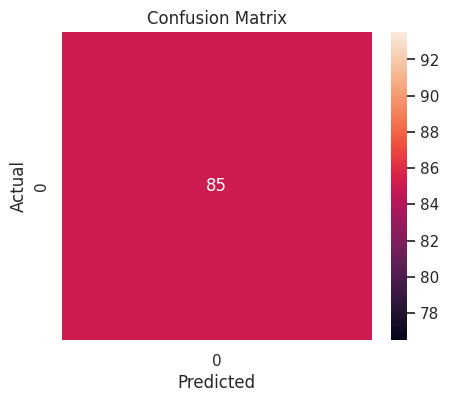

In [6]:

# 7.1 Create binary target from detection_types (example mapping)
if 'detection_types' in data.columns:
    data['is_waf_rule'] = (data['detection_types'] == 'waf_rule').astype(int)
    print('Target distribution:')
    display(data['is_waf_rule'].value_counts())

# 7.2 Prepare features and run a simple RandomForest
clf_features = [c for c in ['bytes_in','bytes_out','session_duration','avg_packet_size'] if c in data.columns]
if 'is_waf_rule' in data.columns and clf_features:
    X = data[clf_features].fillna(0)
    y = data['is_waf_rule']
    stratify_arg = y if y.nunique() > 1 else None
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=stratify_arg)
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('\nClassification report:')
    print(classification_report(y_test, y_pred, zero_division=0))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
else:
    print('Not enough information to train RandomForest (missing columns or target).')


## 8) Additional Visualizations

- Correlation heatmap
- Simple network graph of src_ip -> dst_ip (if dataset small enough)


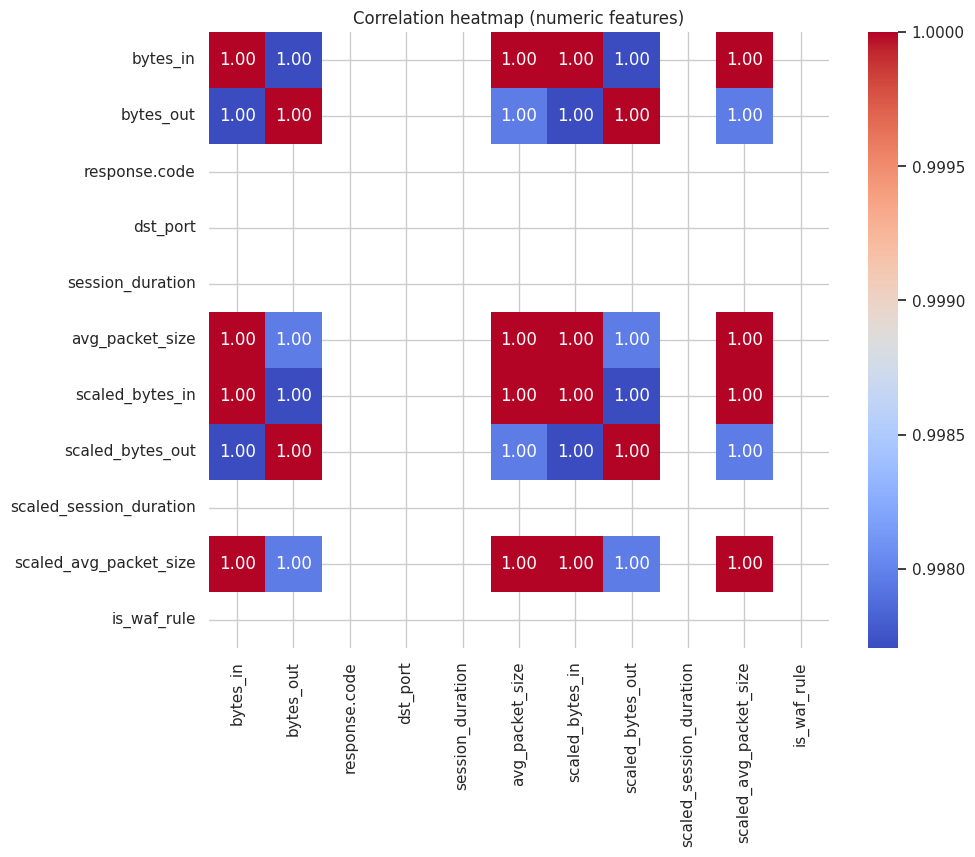

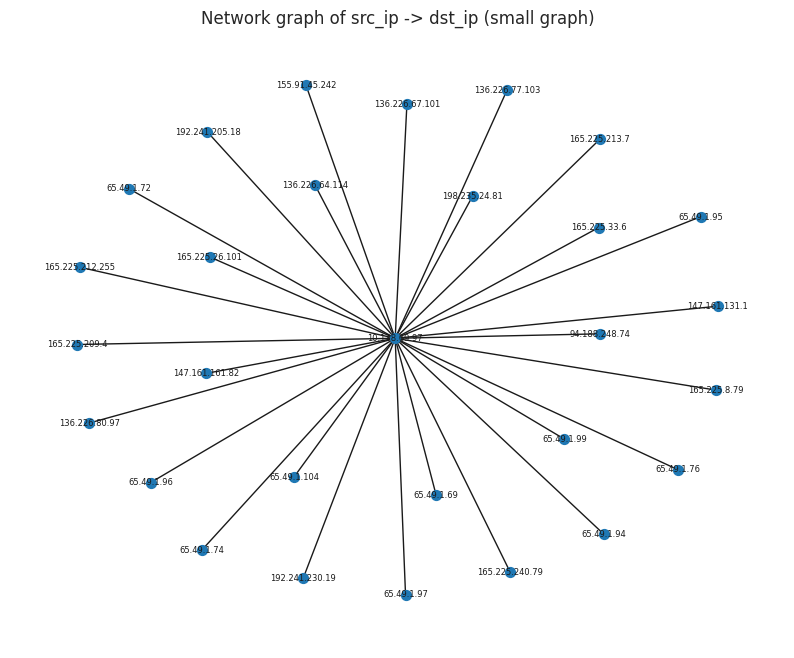

In [7]:

# Correlation heatmap for numeric columns
numeric = data.select_dtypes(include=[np.number])
if not numeric.empty:
    plt.figure(figsize=(10,8))
    sns.heatmap(numeric.corr(), annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation heatmap (numeric features)')
    plt.show()


try:
    import networkx as nx
    unique_src = data['src_ip'].nunique() if 'src_ip' in data.columns else 0
    unique_dst = data['dst_ip'].nunique() if 'dst_ip' in data.columns else 0
    if unique_src + unique_dst < 80 and 'src_ip' in data.columns and 'dst_ip' in data.columns:
        G = nx.from_pandas_edgelist(data, 'src_ip', 'dst_ip')
        plt.figure(figsize=(10,8))
        nx.draw_networkx(G, node_size=50, font_size=6)
        plt.title('Network graph of src_ip -> dst_ip (small graph)')
        plt.axis('off')
        plt.show()
    else:
        print('Skipping network graph (too many unique IPs).')
except Exception as e:
    print('Network graph skipped:', e)


## 9) Conclusions

- Summarize findings
- Recommendations for production use
- Possible improvements

